# Alpha Factor Aggregation
by Christopher van Hoecke Maxwell Margenot and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---
#Summary : 
- [Introduction](#intro)
    - **What is Factor Aggregation and why does it matter?**
- [Normalizing Factor Values](#Normalizing Factor Values.)
    - **The importance of scalling factors for portfolio homogeneity.**
- [Static Weights](#Static Weights)
    - **Crude solution to assing weights to a factor**
- [Dynamic Weights](#Dynamic Weighting)
    - **Using Maching Learning to assign varying weights to each factor**
    - [Defining and building the pipeline](#Defining and building the pipeline)
    - [Running pipeline](#running pipeline)
    - [Testing our ML Pipeline](#Testing our ML Pipeline)
    - [Plugging all into Pipeline.](#Plugging all into Pipeline)
    - [Analysing mega-alpha with alphalens](#analyzing mega-alpha with alphalens)
----

<center> "Two is *sometimes* better than one" </center>
----
<a name = 'intro'></a>
# Introduction
When you come across good alpha factors, you may wish to combine them into one algorithm. Once you've decided what factors to include in your long-short equity, you will need to think of ways to combine them. This can be one way of adding flavor to worn-out, alpha drained and familiar factors as combining factors in a novel way could lend a new perspective on the relative movements in the market that you couldn't access from the factors you chose individually.

We begin by importing the necessary libraries to successfully run Pipeline, create our custom factor and run some computations. Using the imported libraries, we can build our Custom Factors using the built-in class MyFactor(CustomFactor) function. You can read more about building factors and analyzing factors in our [tutorial](https://www.quantopian.com/tutorials/pipeline#lesson10), and [lecture](https://www.quantopian.com/lectures/factor-analysis) pages.  

We use a simple Momentum Factor, a very common form of alpha factor, that come in many shapes and sizes. They all try to get at the same idea however, that securities in motion will stay in motion. Momentum factors try to quantify trends in financial markets and to "ride the wave", so to speak.
Alongside that, we use a Volatility Factor, another common form of alpha factor, which longs highly volatile stocks and shorts the lesser ones. To those, we add a value factor, which simply ranks the ratio between the cash flow and the market cap.  

In [1]:
# ____ Importing Libraries ____ #

from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.factors import CustomFactor, Returns, AverageDollarVolume
from quantopian.pipeline.data import morningstar
import alphalens as al

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neural_network

bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
v = morningstar.valuation

universe = Q500US()

In [2]:
# ____ Defining Factors ____ #

class Momentum(CustomFactor):
    # Momentum Factor
    # Enhanced Price Momentum
    # (12-month momentum - Momentum over last month)/ sigma of past six months
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = 252
    def compute(self, today, assets, out, prices, returns):
        out[:] = ((prices[-21] - prices[-252])/prices[-252] -
                  (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)

class Volatility(CustomFactor):
    # Volatility Factor
    # Volatility of price over last 90 days
    inputs = [USEquityPricing.close]
    window_length = 90
    def compute(self, today, assets, out, prices):
        out[:] = np.nanstd(prices, axis=0)

In [3]:
NUM_LONG_POSITIONS = 100
NUM_SHORT_POSITIONS = 100

value = cfs.free_cash_flow.latest / v.market_cap.latest
momentum = Momentum(mask=universe)
volatility = Volatility(mask=universe)

value_rank  = value.rank()
momentum_rank = momentum.rank()
volatility_rank = volatility.rank()

pipe = Pipeline(
        columns = {
        'Value' : value,
        'Momentum' : momentum,
        'Volatility' : volatility,
        'returns' : Returns(inputs=[USEquityPricing.close], window_length=2),
        'highval' : value_rank.top(NUM_LONG_POSITIONS),
        'lowval' : value_rank.bottom(NUM_SHORT_POSITIONS),
        'highmomentum' : momentum_rank.top(NUM_LONG_POSITIONS),
        'lowmomentum' : momentum_rank.bottom(NUM_SHORT_POSITIONS),
        'highvol' : volatility_rank.top(NUM_LONG_POSITIONS),
        'lowvol' : volatility_rank.bottom(NUM_SHORT_POSITIONS)
    },
    screen = universe)

results = run_pipeline(pipe, '2016-01-01', '2017-01-01')
results.head() 

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Momentum     Value  Volatility  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])  -3.906100  0.011648    0.609595   
                          Equity(24 [AAPL])  1.119194  0.016407    4.228688   
                          Equity(62 [ABT])   0.381835  0.011610    1.804147   
                          Equity(67 [ADSK])  1.019880  0.004877    7.267074   
                          Equity(76 [TAP])   2.259854  0.011173    8.992524   

                                            highmomentum highval highvol  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])         False   False   False   
                          Equity(24 [AAPL])        False   False   False   
                          Equity(62 [ABT])         False   False   False   
                          Equity(67 [ADSK])        False   False    True   
                          Equity(76 [TAP])          True   False    True   

                                            lowmomentum lowval lowvol  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])         True  False   True   
                          Equity(24 [AAPL])       False  False  False   
                          Equity(62 [ABT])        False  False  False   
                          Equity(67 [ADSK])       False  False  False   
                          Equity(76 [TAP])        False  False  False   

                                              returns  
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])  -0.010040  
                          Equity(24 [AAPL]) -0.019474  
                          Equity(62 [ABT])  -0.007733  
                          Equity(67 [ADSK]) -0.021365  
                          Equity(76 [TAP])  -0.006558

Now that we have our data, we can begin working on the due diligence. Before assigning them their respective weights, we should check the mean returns and volume of each factor. This gives us better insight into how each factor performs with respect to the other, which in turn allows us to assign each factor a certain weight **without compromising the homogeneity of the algorithm.**

In [4]:
# ___ Calculating Returns ___ #
momentum_returns = results[results.highmomentum]['returns'].groupby(level=0).mean()- \
                    results[results.lowmomentum]['returns'].groupby(level=0).mean()
    
value_returns = results[results.highval]['returns'].groupby(level=0).mean()- \
                    -results[results.lowval]['returns'].groupby(level=0).fillna(0).mean()
    
value_returns = value_returns.reindex(momentum_returns.index, fill_value=0)

volatility_returns = results[results.highvol]['returns'].groupby(level=0).mean()- \
                    results[results.lowvol]['returns'].groupby(level=0).mean()
    
print 'Momentum return: ', momentum_returns.mean(), '||',  'Volatility: ', momentum_returns.std()
print 'Value return: ', value_returns.mean(),'||' ,' Volatility: ', value_returns.std()
print 'Volatility return: ', volatility_returns.mean(), '||',' Volatility: ', volatility_returns.std()

Momentum return:  -0.00416878739144 || Volatility:  0.0124160894965
Value return:  0.00255983659939 ||  Volatility:  0.0398508395849
Volatility return:  -0.000791575314159 ||  Volatility:  0.00557122197776


Now that we have our momentum, value and volatility factor returns and volatility, we can assign them respective weights. As a simple example, we will assign factors with greatest return (relative to 0) to volatility ratio the lowest weights, and those with smallest ratio, greatest weights. 

In [5]:
# Ratios
momentum_ratio = momentum_returns.mean() / momentum_returns.std()
value_ratio = value_returns.mean() / value_returns.std()
volatility_ratio = volatility_returns.mean() / volatility_returns.std()
print 'Momentum Ratio:', momentum_ratio, '|| Value Ratio:', value_ratio, \
'|| Volatility Ratio:', volatility_ratio

Momentum Ratio: -0.335756873581 || Value Ratio: 0.0642354496431 || Volatility Ratio: -0.142082889053


From these ratios, we determine that the Value Factor should get greatest weight, followed by the Volatility Ratio, then the Momentum Ratio. Arbitrarily, we chose to assign 80% of weights to the Value Factor, 15% to the Volatility Factor, and 5% to the Momentum Factor.

In [6]:
factor_returns = np.array([value_returns.mean(), momentum_returns.mean(), volatility_returns.mean()])

factor_portfolio_weights = np.array([0.80, 0.15, 0.5])
factor_portfolio_return = np.sum(factor_returns * factor_portfolio_weights)
factor_portfolio_covariance = np.cov([momentum_returns.values, 
                                      value_returns.values, 
                                      volatility_returns.values])
factor_portfolio_volatility = factor_portfolio_weights.dot(
                                factor_portfolio_covariance.dot(factor_portfolio_weights.T)
                                                          )

print "Portfolio return: ", factor_portfolio_return, '|', ' Volatility: ', factor_portfolio_volatility

Portfolio return:  0.00102676351372 |  Volatility:  9.07341197679e-05


*Note these weights were chosen pseudo-randomly, given a more rigorous study, we would try to optimize these values to maximize returns and minimize volatility.*

<a name = 'Normalizing Factor Values.'></a>

## Normalizing Factor Values.

When aggregating factors together, we need to consider their individual scales. Certain calculations of factors may simply yield larger values and if we want to combine many different factors that work on different scales, it helps to normalize them so that they don't unduly influence our composite factor. Bellow we show an example of a calculation that is far overweighed by one factor.

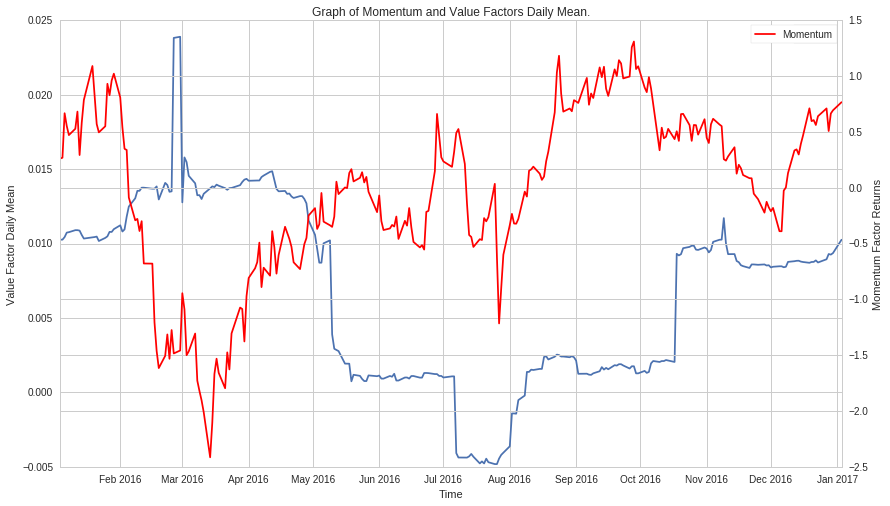

In [7]:
# Here's an example of a calculation that is far overweighed by one factor #
fig, ax1 = plt.subplots()

value_factor = results['Value']
value_factor_daily_mean = value_factor.groupby(level=0).mean()

momentum_factor = results['Momentum']
momentum_factor_daily_mean = momentum_factor.groupby(level=0).mean()

ax1.plot(value_factor_daily_mean)
ax1.set_xlabel('Time')
ax1.set_ylabel('Value Factor Daily Mean')
ax1.legend('Value Factor Daily Mean')

ax2 = ax1.twinx()
ax2.plot(momentum_factor_daily_mean, color = 'red')
ax2.set_ylabel('Momentum Factor Returns')
ax2.legend('Momentum Factor Returns')

plt.title('Graph of Momentum and Value Factors Daily Mean.')
plt.legend();

We can clearly see the scale discrepancies in this graph, the Momentum Factor returns are multiple orders of magnitude greater than those of the Value Factor. Assigning weights to these two factors based on the available information would give the momentum factor an unjustified advantage. We can compute the ratio of daily means obtained by the value factor and the means factor. Doing this we clearly see the unwanted discrepancy between the two factors: 

In [8]:
# ___ Ratio of Value to Momentum ___ #
print "Ratio of Value to Momentum factors: ", \
        (value_factor_daily_mean / momentum_factor_daily_mean).mean()

Ratio of Value to Momentum factors:  0.00886477539166


If we wanted to combine these factors by adding their values, the momentum factor would entirely dominate the value factor, giving us a portfolio that is mostly built on momentum rather than built on both momentum and value equally. To remedy this, we normalize the factors, using the standard normalization function, defined as 

$$ 
F_{normalized} = \frac{X - \mu}{\sigma}
$$

where $\mu$ and $\sigma$ are the mean and standard deviation respectively. *An alternative way of normalizing the data would be to use the `.zscore()` function from the backtester, we use this method later on in the lecture.*

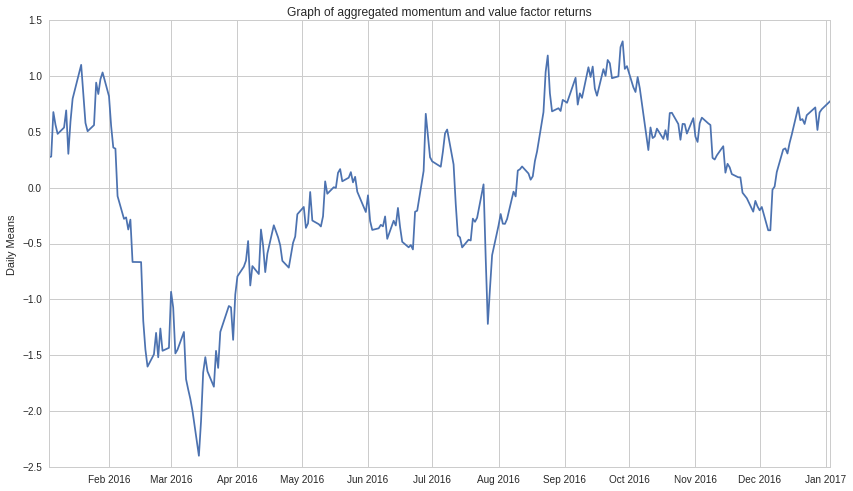

In [9]:
plt.plot(momentum_factor_daily_mean + value_factor_daily_mean)
plt.ylabel('Daily Means')
plt.title('Graph of aggregated momentum and value factor returns');

In [10]:
# Scalling Momentum and Value factors
normalized_momentum = (momentum_factor_daily_mean - momentum_factor_daily_mean.mean())\
                        / momentum_factor_daily_mean.std()
    
normalized_value = (value_factor_daily_mean - value_factor_daily_mean.mean())\
                        / value_factor_daily_mean.std()

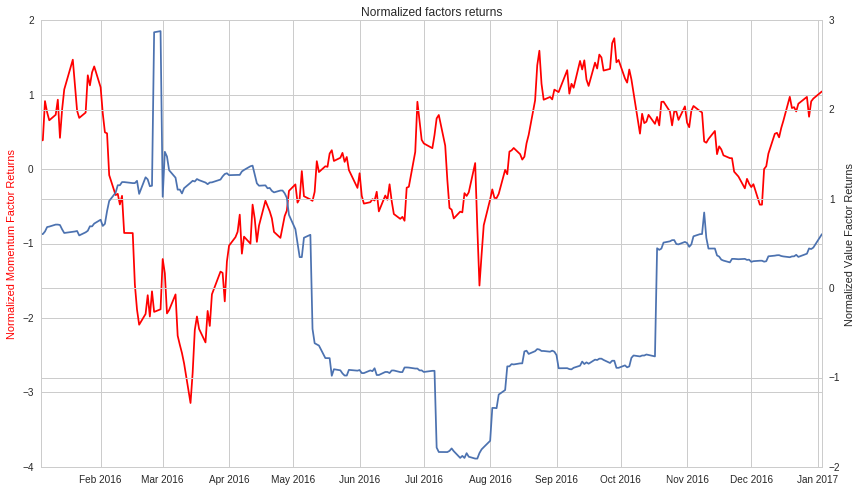

In [11]:
# Plotting Normalized factors
fig, ax1 = plt.subplots()

ax1.plot(normalized_momentum, color = 'red')
ax1.set_ylabel('Normalized Momentum Factor Returns', color = 'red')

ax2 = ax1.twinx()
ax2.plot(normalized_value)
ax2.set_ylabel('Normalized Value Factor Returns')

plt.title('Normalized factors returns');

Plotting the two normalized factors shows us that they are on much more even footing than the non-normalized ones. From here we can proceed to implement them in a strategy where they work in synergy to obtain a greater value of alpha.

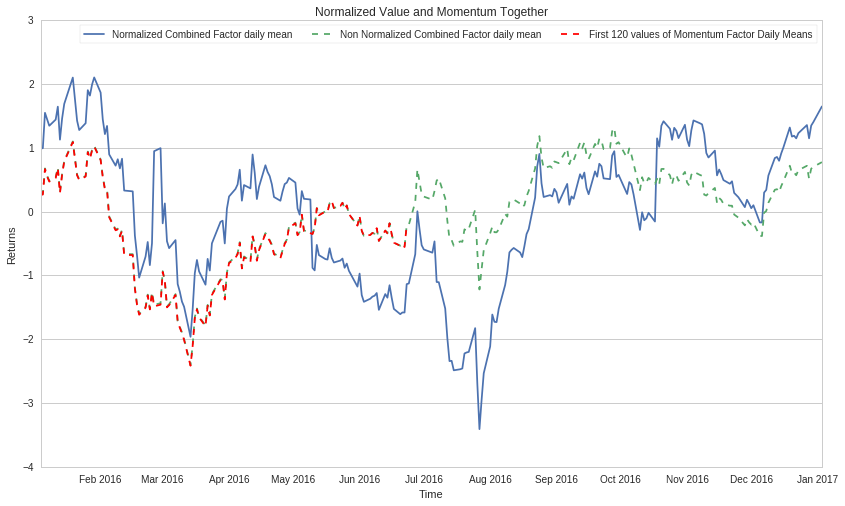

In [12]:
normalized_v_and_m = normalized_momentum + normalized_value


plt.plot(normalized_v_and_m, 
        label = 'Normalized Combined Factor daily mean')
plt.plot(momentum_factor_daily_mean + value_factor_daily_mean, 
         label = 'Non Normalized Combined Factor daily mean',
         linestyle = 'dashed')

plt.plot(momentum_factor_daily_mean[0:120], 
         color = 'red',
         linestyle = 'dashed',
         label = 'First 120 values of Momentum Factor Daily Means')

plt.title("Normalized Value and Momentum Together")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.legend(ncol = 3)
plt.grid(axis='x')

In the plot above we can clearly see the value of having the two factors be normalized. The red dashed graph (momentum factor's daily means) and the green dashed graph (Non-Normalized combined factor's daily mean) are nearly identical. This is because the Momentum Factor's values are much greater than those of the Value factor. The blue normalized graph shows the two factors on equal scale.  

We can start to think of aggregated factors made up of many smaller factors as combinations of long-short equity portfolios/assets themselves. By combining many of these assets into one factor (portfolio), we get the same effect that you get from portfolio diversification ~ *higher return for less volatility.*


<a name = 'Static Weights'></a>
# Static Weights
The above combined factor is an example of a static aggregation method. We simply add the two normalized factors together so that the aggregate factor is 50% momentum, 50% value. We have selected a weighting scheme and will carry it forward without any modifications. *An alternative approach is to adjust the weighting between the underlying factors.*

As before, we begin by creating our factor. Here we use the SPY-Volatility factor, which simply the standard deviation of spy. 

In [13]:
# ___ Building Custom Factor ___ #
class SPYVol(CustomFactor):
    inputs = [Returns(window_length=2)]    
    def compute(self, today, assets, out, returns):
        idx = np.where(assets == 8554) # Check the dataframe for the SID of SPY
        spy_returns = returns[:,idx]
        out[:] = np.nanstd(spy_returns)

Defining short and long term volatility as the 21 and 63 day volatility respectively, and normalizing our values allows us to run the pipeline on our selected universe. In this case, pipeline will output the tradeoff_factor, the returns, along with a Boolean expression of the high tradeoff and low tradeoff.

In [14]:
# Calculating short and long term volatility
short_term_spy_vol = SPYVol(window_length=21)
long_term_spy_vol = SPYVol(window_length=63)

# Zscore() to normalize
tradeoff_factor = Momentum().zscore() * (short_term_spy_vol/long_term_spy_vol) + \
            Volatility().zscore() * (1-(short_term_spy_vol/long_term_spy_vol))

In [15]:
# Ranking and running pipeline
tradeoff_rank = tradeoff_factor.rank()

pipe = Pipeline(
    columns = {
        "MomentumVolSwitch" : tradeoff_factor,
        'returns': Returns(inputs=[USEquityPricing.close], window_length=2),
        "hightradeoff" : tradeoff_rank.top(NUM_LONG_POSITIONS),
        "lowtradeoff" : tradeoff_rank.bottom(NUM_SHORT_POSITIONS)
    },
    screen=universe
)

tradeoff_results = run_pipeline(pipe, '2016-01-01', '2017-01-01')

In [16]:
tradeoff_results.head()

MomentumVolSwitch hightradeoff  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])           -2.089693        False   
                          Equity(24 [AAPL])           0.537339        False   
                          Equity(62 [ABT])            0.152191        False   
                          Equity(67 [ADSK])           0.484903        False   
                          Equity(76 [TAP])            1.132976        False   

                                            lowtradeoff   returns  
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])        False -0.010040  
                          Equity(24 [AAPL])       False -0.019474  
                          Equity(62 [ABT])        False -0.007733  
                          Equity(67 [ADSK])       False -0.021365  
                          Equity(76 [TAP])        False -0.006558

In [17]:
tradeoff_returns = tradeoff_results[tradeoff_results.hightradeoff]['returns'].groupby(level=0).mean()- \
                   tradeoff_results[tradeoff_results.lowtradeoff]['returns'].groupby(level=0).mean()

In [18]:
print 'Tradeoff mean returns :', tradeoff_returns.mean()
print 'Tradeoff standard deviation :', tradeoff_returns.std()

Tradeoff mean returns : -0.0126726445716
Tradeoff standard deviation : 0.0431842268144


In [19]:
def scale(value):
    return (value - value.mean())/value.std()

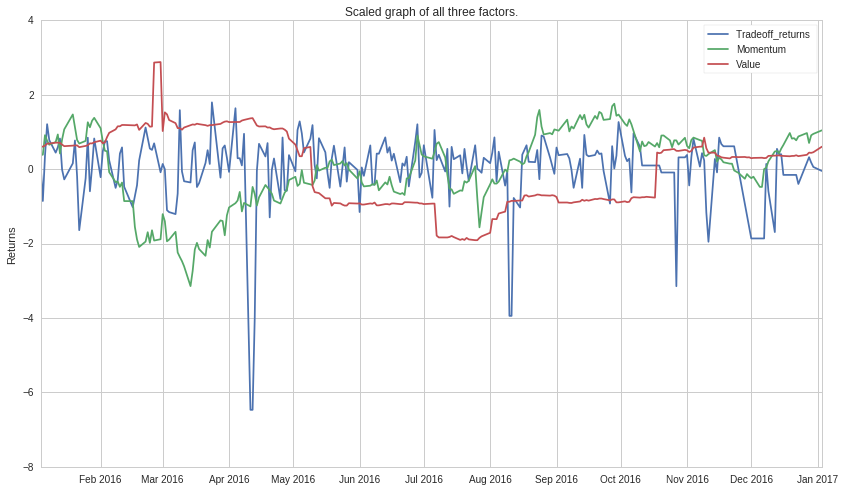

In [20]:
plt.plot(scale(tradeoff_returns.fillna(method = 'ffill')), label = 'Tradeoff_returns ')
plt.plot(scale(momentum_factor_daily_mean))
plt.plot(scale(value_factor_daily_mean))
plt.title('Scaled graph of all three factors.')
plt.ylabel('Returns')
plt.legend();

Now that we have computed the mean returns and standard deviation of this factor, we can find efficient ways of combining it to the Momentum and Value factors. 

In [21]:
# Mean and Standard Deviation of all four factors. 
print 'Means:', tradeoff_returns.mean(), '||', momentum_factor_daily_mean.mean(), \
                '||', value_factor_daily_mean.mean(), '||', volatility_returns.mean()

print 'Standard deviations:', tradeoff_returns.std(), '||', momentum_factor_daily_mean.std(), \
                '||', value_factor_daily_mean.std(), '||', volatility_returns.mean()

Means: -0.0126726445716 || -0.0270783673986 || 0.00662625960785 || -0.000791575314159
Standard deviations: 0.0431842268144 || 0.759855672779 || 0.00599811444754 || -0.000791575314159


Yet again, we would like to assign greater weights to factors with Sharpe ratio's closest to one (returns to volatility)

In [22]:
# Sharpe Calculations
print 'tradeoff ratio :', tradeoff_returns.mean() / tradeoff_returns.std()
print 'momentum ratio:', momentum_ratio
print 'value ratio:', value_ratio
print 'volatility ratio:', volatility_ratio

tradeoff ratio : -0.293455400419
momentum ratio: -0.335756873581
value ratio: 0.0642354496431
volatility ratio: -0.142082889053


Now that we have all the four Sharpe Ratios, we can set about assigning weights and checking the returns of our combined portfolio versus the individual factor ones. Again, we will pseudo-arbitrarily assign the weights. We leave it as an exercise to the user to find the best weights associated with this timeframe. 

In [23]:
# Calculating Portfolio Returns
portfolio_returns = 0.05 * tradeoff_returns.fillna(method = 'ffill') + \
                0.05 * momentum_returns + \
                0.8 * value_returns + \
                0.1 * volatility_returns

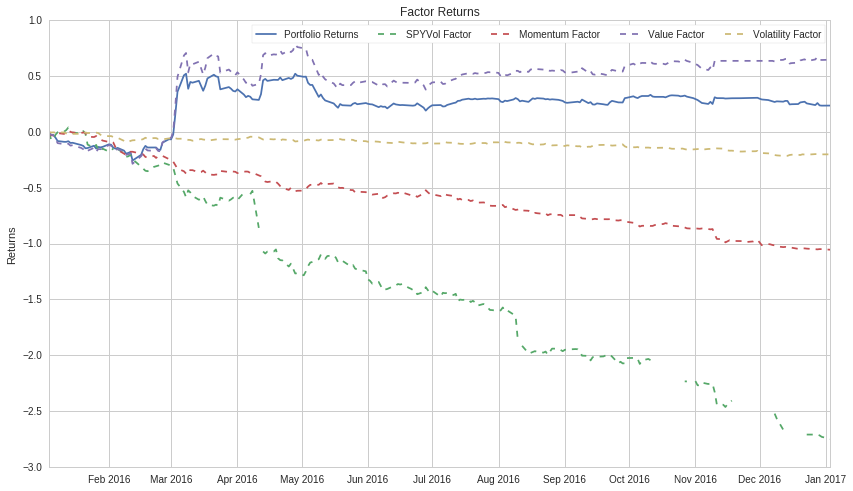

In [24]:
# Plotting cummulative Returns of portfolio as well as four factors. 
plt.plot(np.cumsum(portfolio_returns.fillna(method = 'ffill')), label = 'Portfolio Returns')
plt.plot(np.cumsum(tradeoff_returns), linestyle = 'dashed', label = 'SPYVol Factor')
plt.plot(np.cumsum(momentum_returns), linestyle = 'dashed', label = 'Momentum Factor')
plt.plot(np.cumsum(value_returns), linestyle = 'dashed', label = 'Value Factor')
plt.plot(np.cumsum(volatility_returns), linestyle= 'dashed', label = 'Volatility Factor')
plt.legend(ncol = 5, bbox_to_anchor = (1, 1))
plt.ylabel('Returns')
plt.title('Factor Returns');

We can see that our portfolio of combined factors does better than it would had we constructed a single portfolio. *To state with confidence that the combination of factors is more beneficial, we would have to check it’s out of sample performances.*

Note however that the factor's performance varies with time, whereas our weights do not. This is a cause for concern especially when markets change regime, as our factors are no longer weighed optimally. We tackle that problem in the next section on Dynamic Weighting.

----
<a name = 'Dynamic Weighting'></a>
# Dynamic Weighting.
While stationary weights are helpful at flavoring weaker signals, it does not insure against an ever-changing landscape. To ensure that each asset's assigned weight truly is the optimal one, we need to dynamically allocate them, which simply means allocating the weights as a function of time.
There are multiple ways of going about it; one crude but feasible option is with if and for statements. In this lecture however, we will work with the scikit library to use Machine Learning to find the optimal weights associated with each factor.
<a name = 'Defining and building the pipeline'></a>
### Defining and building the pipeline
We start our study by picking 5 factors which will be implemented  in our algorithm. Here we chose `EBITDA to Yield`, as well as `EBIT to Assets`, `Net income margin`, `3 month volume`, and `Working Capital to Assets`. You can find all datasets and how to implement  them in research and algorithm environments in Quantopian's [data page](https://www.quantopian.com/data).

In [25]:
# Defining factors. 
from quantopian.pipeline.data.zacks import EarningsSurprises

def make_factors(): 
    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
    
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest    
        
    def EPS_Surprise():
        return EarningsSurprises.eps_amt_diff_surp.latest

    all_factors = {
        'Asset_To_Equity_Ratio' : Asset_To_Equity_Ratio,
        'Capex_To_Cashflows' : Capex_To_Cashflows,
        'EBITDA_Yield' : EBITDA_Yield,        
        'EPS_Surprise' : EPS_Surprise,
    }        
    
    return all_factors

In the interest of saving time, we have defined a `make_factors` function, which returns a dictionary of all our factors. Now that we have the factors set up, we need to find a universe to work on. We chose the predefined Q500US equities universe. Because of the common practices associated with machine learning, we set about building a Train-Test universe, along with historic data, and 'future' data which our model will attempt to predict. Here we will predict 3-days returns and train our model on daily data. *You can read more about the machine learning classification processes [here](https://en.wikipedia.org/wiki/Machine_learning#Model_assessments).*   

------
<a name ='running pipeline'></a>
### Running pipeline
Bellow, we run pipeline and get our historic data by defining a `make_history_pipeline` function which takes `factors`, `universe`, and the `number_of_forward_days` as parameters and outputs a dataframe of assets that meet our qualifications. You need not bother with the logistics of this function, besides knowing that plugging it into the pipeline will output a Multi-Index DataFrame with days and assets as indices, and ranked factors with respect to each other as values. Recall, `n_fwd_days = 3` since we are trying to predict 3-day returns.

In [26]:
# Defining universe and factors.
universe = Q500US()
factors = make_factors()

# number of days to compute returns over
n_fwd_days = 3

# Defining historic pipeline.
def make_history_pipeline(factors, universe, n_fwd_days=3):
    # Call .rank() on all factors and mask out the universe
    factor_ranks = {name: f().rank(mask=universe) for name, f in factors.iteritems()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

In [27]:
# Running Historic Pipeline.
start = pd.Timestamp("2013-01-01")
end = pd.Timestamp("2013-05-01")
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['Date', 'Security']

In [28]:
results.sample(2)

,,Asset_To_Equity_Ratio,Capex_To_Cashflows,EBITDA_Yield,EPS_Surprise,Returns
Date,Security,,,,,
2013-03-11 00:00:00+00:00,Equity(42277 [ZNGA]),52.0,254.0,373.0,285.0,-0.008357
2013-01-03 00:00:00+00:00,Equity(5822 [PCP]),34.0,133.0,121.0,53.0,0.017599


We now have our five factors associated with each asset. We would like to find a way to combine theses weakly predictive factors such that we maximize alpha. *Note the Returns columns: this the column we are trying to predict.*

However, before successfully digging into the `scikit` classification, we need to do some additional transformation to our data to match the required inputs : 
- Our factor ranks need to be shifted in order to align with the future return `n_fwd_days` in the future. 
- We need to find the top and bottom 30% stocks based on their return *(we do this to ignore stocks that don't move that much)*. 
- And finally, we need to bin the returns by their percentile to turn the Machine Learning problem into a classification one.  

We define the `shift_mask_data` utility function to do all this for us.  As well as the `get_last_value` function that will give us the last factor values. *(You can ignore this function for now as it will be use later in the lecture.)*

In [29]:
def shift_mask_data(X, Y, upper_percentile=70, lower_percentile=30, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

Before successfully running the `shift_mask_data`, we need to make sure our dataset matches the required input of our function. Namely, we need our data to be of the `numpy.array` type and not `pandas DataFrame` which we currently have. *The challenge here is not compromising the data as we shift from the time sensitive DataFrame to the array.* 

In [30]:
# Manipulate the data to be in the form expected by shift_mask_data()

results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')

Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)...

results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 
    1)
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 
    0)

Here we used the `unstack` function to change the returns from a Multi-Index series to a DataFrame. 
We also use the `to_panel` function to transform the stacked dataframe format into a 3D panel. 
*You can read more about the unstack and to_panel functions and what they do [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html) and [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_panel.html)*  We can print the results out to make sure we have not compromised the structure of the data.

In [31]:
print 'RETURNS:\n', returns.head(2)
print '----'
print 'Y VALUES:\n', Y[0][0:2]

RETURNS:
Date                       Security         
2013-01-02 00:00:00+00:00  Equity(2 [ARNC])    -0.026286
                           Equity(24 [AAPL])   -0.005859
Name: Returns, dtype: float64
----
Y VALUES:
[-0.02628571 -0.00585934]


In [32]:
print 'RESULTS WITHOUT RETURNS:\n', results_wo_returns.head(2)
print '----'
print 'X VALUES:\n', X[0][0]

RESULTS WITHOUT RETURNS:
                     Asset_To_Equity_Ratio  Capex_To_Cashflows  EBITDA_Yield  \
Date       Security                                                            
2013-01-02 ARNC                      318.0               439.0          16.0   
           AAPL                       69.0               123.0         383.0   

                     EPS_Surprise  
Date       Security                
2013-01-02 ARNC               NaN  
           AAPL              91.0  
----
X VALUES:
[ 318.  439.   16.   nan]


Now that we have all the data set up and verified, we need to split it into training (80%) and testing(20%). Our model will attempt to match the training data, and run it on the 'testing' data as an accuracy test. 
*Note : Since we are dealing with a timeseries, we need to split along the time dimension to make sure we only test on future data.*

In [33]:
# Train-test split
train_size_perc = 0.5
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

In [34]:
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

With our Train and Test arrays ready, we can set about testing our data using Machine Learning Classifiers.

----
<a name = 'Testing our ML Pipeline'></a>
### Testing our ML Pipeline.
Now that we have our train and test datasets, we can run our model at test it for its accuracy. We will use the `scikit` library's `Gradient Boosting Classifier` to 'rank' our factors from most to least valuable. We begin by defining imputer and scaler, which transform the data for completing missing values and standardizes the data by scaling it to a given range. 
*You can read about scikit's Gradient Boosting Classifier and other classifiers [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)*

In [35]:
# Train classifier
imputer = preprocessing.Imputer() # Imputation transformer for completing missing values.
scaler = preprocessing.MinMaxScaler() # Standardizes features by scaling each feature to a given range.

# n_estimators controls how many weak classifiers are fit
clf =  GradientBoostingClassifier(n_estimators=200, learning_rate=0.1) 

X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)

clf.fit(X_train_trans, Y_train_shift);

In [36]:
Y_pred = clf.predict(X_train_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred) * 100))

Accuracy on train set = 63.69%


In [37]:
# Transform test data
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)

To test the accuracy of our model, we use the `metrics` parameter to find the accuracy score, and the log loss of our predicted data, and our predicted probability. You can get more information about how to implement these by doing `metrics.accuracy_score??`, or `metrics.log_loss??`.  *You can also read more about log_loss [here](https://en.wikipedia.org/wiki/Loss_functions_for_classification)*

In [38]:
# Predictions
Y_pred = clf.predict(X_test_trans)

Y_pred_prob = clf.predict_proba(X_test_trans)

In [39]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))

Accuracy on test set = 51.17%
Log-loss = 0.70141


We can visualize our factors using bar graphs, ranking them from most to least valuable based on their Gini Coefficient. You can read more about Gini Coefficients [here](https://en.wikipedia.org/wiki/Gini_coefficient). We have reached an important part of our study. By knowing which factors are more valuable that the others *(in each time period)*, we can start assigning greater weights to the best rank factors. Furthermore, since the process is automated, our model can account for changes over time, and adapt itself to perpetually tell us what the most valuable factor is given the data. In the next step, we implement our study into pipeline to do exactly that.

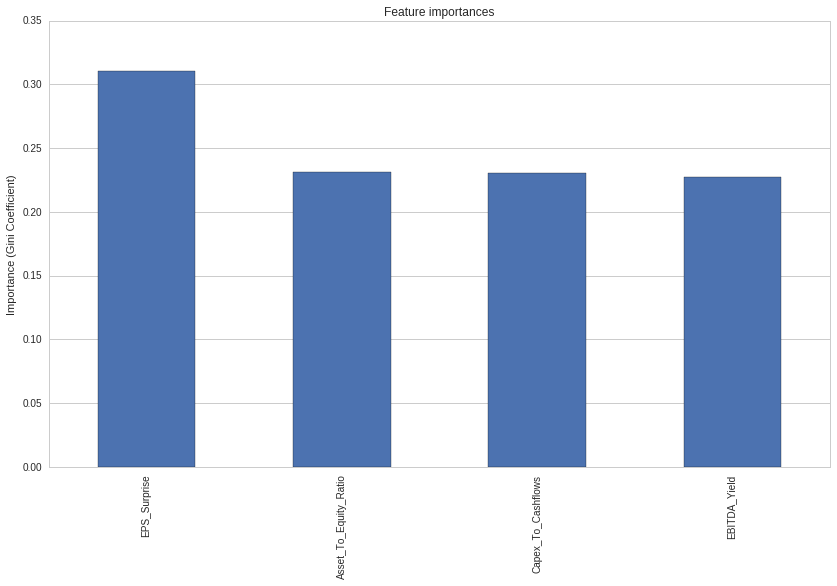

In [40]:
feature_importances = pd.Series(clf.feature_importances_, index=results_wo_returns.columns)
feature_importances = feature_importances.sort_values(ascending = False)
ax = feature_importances.plot(kind = 'bar')
ax.set(ylabel = 'Importance (Gini Coefficient)', title = 'Feature importances')
ax.grid(axis = 'x');

### Out of Sample Testing.
Now that we have successfully found the most valuable factors in the period from `2013-01-01` to `2013-05-01`, we can now find the most important factors during the period `2013-05-01 - 2013-10-01`. Running the same functions as before, we again use the GradientBoostinClassifier to classify our factors, using a training size of 0.8.

In [41]:
# Running Historic Pipeline.
start = pd.Timestamp("2013-05-01")
end = pd.Timestamp("2013-10-01")
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['Date', 'Security']

In [42]:
# Manipulate the data to be in the form expected by shift_mask_data()

results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')

Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)...

results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 
    1)
results_wo_returns.index = results_wo_returns.index.set_levels(
    results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 
    0)

In [43]:
# Train-test split
train_size_perc = 0.5
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

In [44]:
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

In [45]:
# Train classifier
imputer = preprocessing.Imputer() # Imputation transformer for completing missing values.
scaler = preprocessing.MinMaxScaler() # Standardizes features by scaling each feature to a given range.

# n_estimators controls how many weak classifiers are fit
clf =  GradientBoostingClassifier(n_estimators=200, learning_rate=0.1) 

X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)

clf.fit(X_train_trans, Y_train_shift);

In [46]:
Y_pred = clf.predict(X_train_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred) * 100))

Accuracy on train set = 61.37%


In [47]:
# Transform test data
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)

In [48]:
# Predictions
Y_pred = clf.predict(X_test_trans)

Y_pred_prob = clf.predict_proba(X_test_trans)

In [49]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))

Accuracy on test set = 50.40%
Log-loss = 0.70547


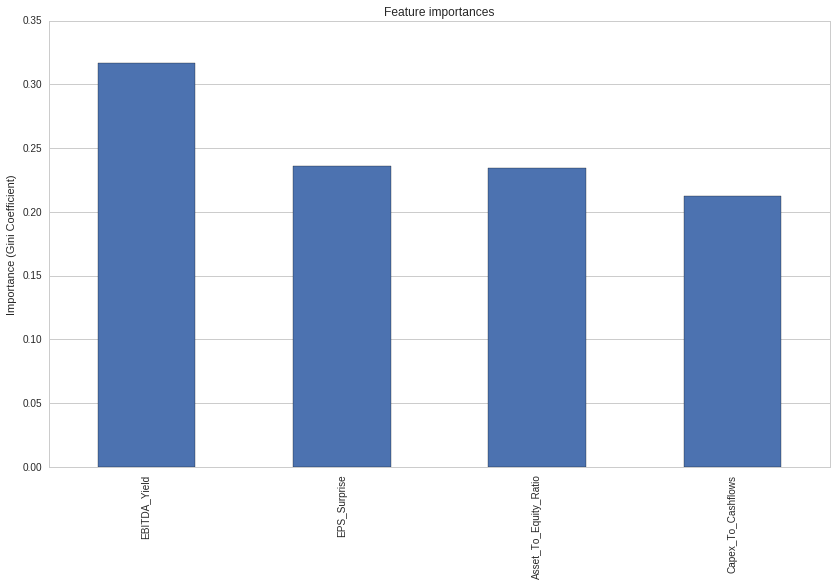

In [50]:
feature_importances = pd.Series(clf.feature_importances_, index=results_wo_returns.columns)
feature_importances = feature_importances.sort_values(ascending = False)
ax = feature_importances.plot(kind = 'bar')
ax.set(ylabel = 'Importance (Gini Coefficient)', title = 'Feature importances')
ax.grid(axis = 'x');

From the bar graph above, we can clearly see the advantage of dynamically allocated factor aggregation. Had we assigned static weights given the Gini score during the five months starting January 2013, we would have given greater importance to the EPS-Surprise factor, which greatly underperforms in the period from May to December of 2013.
 
 
*If you'd like to read more about alpha-factor aggregation and how to incorporate them into a trading algorithm, check out the 'Machine Learning on Quantopian : Building an Algorithm' posts [here](https://www.quantopian.com/posts/machine-learning-on-quantopian-part-3-building-an-algorithm).*

This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company. In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.